In [8]:
import numpy as np
import math

In [9]:
def scaled_dot_product_attention(Q, K, V, mask=None):
    """
    Q, K, V: shape (batch_size, heads, seq_len, depth)
    """
    d_k = Q.shape[-1]
    
    # Transposición correcta para producto escalar
    scores = np.matmul(Q, K.transpose(0, 1, 3, 2)) / math.sqrt(d_k)
    
    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)
    
    attention_weights = softmax(scores)
    output = np.matmul(attention_weights, V)  # (batch, heads, seq_len, depth)
    
    return output, attention_weights

In [10]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Pesos de proyección para Q, K, V y salida
        self.W_q = np.random.rand(d_model, d_model)
        self.W_k = np.random.rand(d_model, d_model)
        self.W_v = np.random.rand(d_model, d_model)
        self.W_o = np.random.rand(d_model, d_model)

    def split_heads(self, x, batch_size):
        """
        Divide la dimensión d_model en (num_heads, depth)
        x: (batch_size, seq_len, d_model)
        """
        x = x.reshape(batch_size, -1, self.num_heads, self.depth)
        return x.transpose(0, 2, 1, 3)  # (batch, heads, seq_len, depth)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.shape[0]
        
        # Lineares
        Q = Q @ self.W_q
        K = K @ self.W_k
        V = V @ self.W_v

        # División de cabezas
        Q = self.split_heads(Q, batch_size)
        K = self.split_heads(K, batch_size)
        V = self.split_heads(V, batch_size)
        
        # Atención por cabeza
        scaled_attention, attention_weights = scaled_dot_product_attention(Q, K, V, mask)
        
        # Concatenar cabezas
        scaled_attention = scaled_attention.transpose(0, 2, 1, 3)  # (batch, seq_len, heads, depth)
        concat_attention = scaled_attention.reshape(batch_size, -1, self.d_model)
        
        # Proyección final
        output = concat_attention @ self.W_o  # (batch_size, seq_len, d_model)
        return output, attention_weights

In [11]:
def positional_encoding(seq_len, d_model):
    PE = np.zeros((seq_len, d_model))
    position = np.arange(0, seq_len)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
    
    PE[:, 0::2] = np.sin(position * div_term)
    PE[:, 1::2] = np.cos(position * div_term)
    
    return PE  # (seq_len, d_model)

In [12]:
class FeedForwardNetwork:
    def __init__(self, d_model, d_ff):
        self.W1 = np.random.rand(d_model, d_ff)
        self.b1 = np.zeros((d_ff,))
        self.W2 = np.random.rand(d_ff, d_model)
        self.b2 = np.zeros((d_model,))
    
    def forward(self, x):
        return self.linear2(relu(self.linear1(x)))
    
    def linear1(self, x):
        return x @ self.W1 + self.b1
    
    def linear2(self, x):
        return x @ self.W2 + self.b2

def relu(x):
    return np.maximum(0, x)

In [13]:
class EncoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = FeedForwardNetwork(d_model, d_ff)
    
    def layer_norm(self, x, eps=1e-6):
        mean = x.mean(-1, keepdims=True)
        std = x.std(-1, keepdims=True)
        return (x - mean) / (std + eps)
    
    def forward(self, x):
        # Multi-Head Attention
        attn_output, _ = self.mha.forward(x, x, x)  # Self-attention
        out1 = self.layer_norm(x + attn_output)     # Residual + Norm
        
        # Feed Forward Network
        ffn_output = self.ffn.forward(out1)
        out2 = self.layer_norm(out1 + ffn_output)   # Residual + Norm
        
        return out2

In [14]:
#Ejemplo de uso: un paso completo del encoder
# Ejemplo de uso
seq_len = 5
d_model = 16
num_heads = 4
d_ff = 64
batch_size = 2

x = np.random.rand(batch_size, seq_len, d_model)
x += positional_encoding(seq_len, d_model)

encoder = EncoderBlock(d_model, num_heads, d_ff)
output = encoder.forward(x)

print("Output del encoder:\n", output)

Output del encoder:
 [[[ 8.29602304e-04 -1.70949625e+00  1.09103443e+00  1.93408529e-02
   -6.60006384e-03 -7.72712471e-01 -9.75950359e-01  1.94081440e+00
   -9.92474767e-01  7.45105970e-01  1.45831321e+00  9.54554894e-02
   -1.61088425e+00  2.65656669e-02  5.19075773e-01  1.71582771e-01]
  [ 6.44880454e-03 -1.73955239e+00  1.08118103e+00  1.15941705e-02
   -1.17765027e-02 -8.08831878e-01 -9.47519790e-01  1.95061640e+00
   -9.93378965e-01  7.23354451e-01  1.45187349e+00  8.67897913e-02
   -1.58703336e+00  3.94749734e-02  4.92110518e-01  2.44649261e-01]
  [ 5.55302718e-03 -1.75441453e+00  1.15842156e+00 -9.32504349e-02
    3.34089350e-02 -8.10591212e-01 -9.24294786e-01  1.96814147e+00
   -1.01534767e+00  7.30406508e-01  1.45791281e+00  2.34049757e-02
   -1.48799799e+00 -1.04670934e-02  4.64396804e-01  2.54717615e-01]
  [-9.42610725e-03 -1.80138997e+00  1.14909507e+00 -6.05822334e-02
    9.80847667e-03 -7.61286898e-01 -9.21821670e-01  1.96344270e+00
   -9.77945726e-01  7.04532403e-01  1.

In [15]:
def create_look_ahead_mask(seq_len):
    """
    Crea una máscara triangular inferior (0s arriba de la diagonal)
    """
    return np.tril(np.ones((seq_len, seq_len)))


In [16]:
class DecoderBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.mha1 = MultiHeadAttention(d_model, num_heads)  # Masked Self-Attention
        self.mha2 = MultiHeadAttention(d_model, num_heads)  # Encoder-Decoder Attention
        self.ffn = FeedForwardNetwork(d_model, d_ff)
    
    def layer_norm(self, x, eps=1e-6):
        mean = x.mean(-1, keepdims=True)
        std = x.std(-1, keepdims=True)
        return (x - mean) / (std + eps)
    
    def forward(self, x, enc_output, look_ahead_mask=None):
        """
        x: salida anterior del decoder (batch_size, seq_len, d_model)
        enc_output: salida del encoder (batch_size, seq_len_encoder, d_model)
        """
        # 1. Masked Multi-Head Self-Attention
        attn1, _ = self.mha1.forward(x, x, x, mask=look_ahead_mask)
        out1 = self.layer_norm(x + attn1)
        
        # 2. Multi-Head Attention con encoder como clave y valor
        attn2, _ = self.mha2.forward(out1, enc_output, enc_output)
        out2 = self.layer_norm(out1 + attn2)
        
        # 3. Feed Forward Network
        ffn_output = self.ffn.forward(out2)
        out3 = self.layer_norm(out2 + ffn_output)
        
        return out3

In [17]:
# Parámetros
seq_len_dec = 5
seq_len_enc = 5
d_model = 16
num_heads = 4
d_ff = 64
batch_size = 2

# Entradas simuladas
decoder_input = np.random.rand(batch_size, seq_len_dec, d_model)
encoder_output = np.random.rand(batch_size, seq_len_enc, d_model)

# Codificación posicional
decoder_input += positional_encoding(seq_len_dec, d_model)

# Crear máscara para prevenir atención al futuro
look_ahead_mask = create_look_ahead_mask(seq_len_dec)
look_ahead_mask = look_ahead_mask[np.newaxis, np.newaxis, :, :]  # (1, 1, seq_len, seq_len)

# Bloque del decoder
decoder = DecoderBlock(d_model, num_heads, d_ff)
output = decoder.forward(decoder_input, encoder_output, look_ahead_mask)

print("Output del decoder:\n", output)

Output del decoder:
 [[[ 6.62251661e-01 -2.62233411e+00  3.57075545e-01 -2.72393838e-01
    1.08499981e+00 -3.11865728e-01 -8.50496218e-03 -1.72706637e-03
    9.51196896e-01  1.27704357e+00  1.30383199e+00 -1.02907762e+00
   -4.11775387e-01 -5.83632380e-01  6.16607793e-01 -1.01169616e+00]
  [ 6.65186279e-01 -2.62720234e+00  3.61478279e-01 -2.87615776e-01
    1.07669985e+00 -3.05864486e-01 -2.24191008e-03  3.45934266e-03
    9.51708340e-01  1.28763339e+00  1.30076315e+00 -1.01833329e+00
   -4.31604828e-01 -5.68090963e-01  6.04765072e-01 -1.01074011e+00]
  [ 6.69188289e-01 -2.63153760e+00  3.71865031e-01 -3.06128370e-01
    1.07234237e+00 -2.93038849e-01 -3.24324131e-03  7.82362583e-03
    9.54256213e-01  1.27260928e+00  1.30282768e+00 -1.02881550e+00
   -4.34068463e-01 -5.55434587e-01  6.05966944e-01 -1.00461282e+00]
  [ 6.58845477e-01 -2.63555664e+00  3.78291236e-01 -3.04476337e-01
    1.06629296e+00 -2.93281415e-01 -1.59519026e-03  1.27852900e-02
    9.56667016e-01  1.27168016e+00  1.

#PRUEBAS

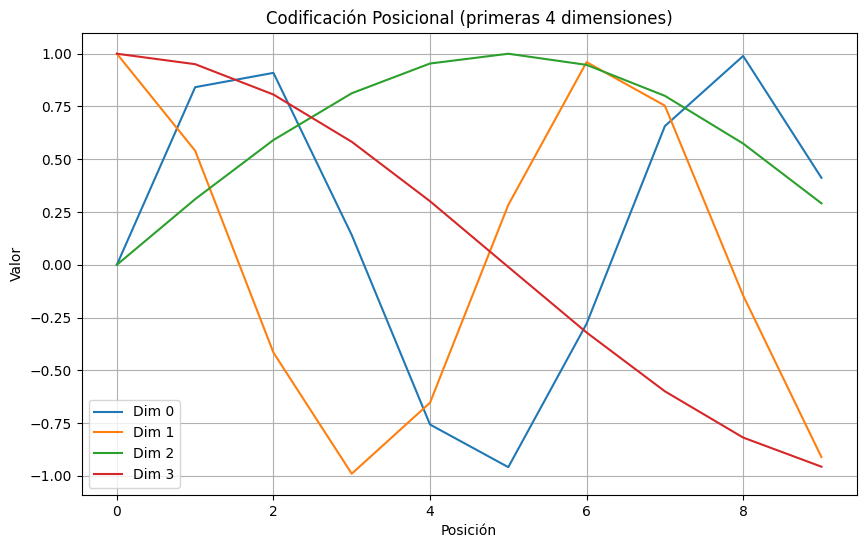

In [19]:
#Prueba 1: Codificación Posicional

import matplotlib.pyplot as plt

# Probar codificación posicional
d_model = 16
seq_len = 10

PE = positional_encoding(seq_len, d_model)

plt.figure(figsize=(10, 6))
plt.title("Codificación Posicional (primeras 4 dimensiones)")
for i in range(4):
    plt.plot(PE[:, i], label=f"Dim {i}")
plt.xlabel("Posición")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
#Prueba 2: Scaled Dot-Product Attention

# Datos simples
Q = np.random.rand(1, 1, 3, 4)  # (batch, heads, seq_len_q, d_k)
K = np.random.rand(1, 1, 3, 4)
V = np.random.rand(1, 1, 3, 4)

output, att_weights = scaled_dot_product_attention(Q, K, V)

print("Output:\n", output)
print("Pesos de atención (softmax):\n", att_weights)

Output:
 [[[[0.19825242 0.42874249 0.59415635 0.30821991]
   [0.18223114 0.4683578  0.53452144 0.28881904]
   [0.18726616 0.46311061 0.54442404 0.29090302]]]]
Pesos de atención (softmax):
 [[[[0.38209295 0.29187659 0.32603046]
   [0.4439639  0.28258333 0.27345277]
   [0.43376074 0.27734639 0.28889287]]]]


In [21]:
# Prueba 3: Multi-Head Attention

# Parámetros
batch_size = 1
seq_len = 4
d_model = 8
num_heads = 2

# Input artificial
x = np.random.rand(batch_size, seq_len, d_model)

# Ejecutar atención multi-cabeza
mha = MultiHeadAttention(d_model, num_heads)
out, att_weights = mha.forward(x, x, x)

print("Output Multi-Head Attention:\n", out)

Output Multi-Head Attention:
 [[[ 7.08825408  9.89065049 12.03229191  5.63949502 10.50194056
   10.52271588 12.98940214  8.78741701]
  [ 7.17918352 10.03931503 12.22416635  5.71640069 10.65463609
   10.67118886 13.17053742  8.91568856]
  [ 7.43352148 10.35544774 12.61760891  5.91667162 10.98506972
   11.00152042 13.60765355  9.21659682]
  [ 7.29617507 10.16692427 12.37989161  5.80569643 10.7902343
   10.80771897 13.35876687  9.04371641]]]


In [22]:
# Prueba 4: Bloque del Encoder

batch_size = 1
seq_len = 5
d_model = 16
num_heads = 4
d_ff = 64

x = np.random.rand(batch_size, seq_len, d_model)
x += positional_encoding(seq_len, d_model)

encoder = EncoderBlock(d_model, num_heads, d_ff)
out_enc = encoder.forward(x)

print("Salida del bloque del encoder:\n", out_enc)

Salida del bloque del encoder:
 [[[ 1.74868108 -0.88040002  1.54175373  1.10117377 -0.22159391
   -0.79524131 -0.93266007  0.59318337 -0.33309778 -0.12738771
   -1.69990239  0.48362058 -0.03656025 -1.15717527 -0.59796806
    1.31357427]
  [ 1.80631381 -0.90403983  1.54707666  1.09985972 -0.20776022
   -0.81231781 -0.92342401  0.50949954 -0.31268924 -0.13164915
   -1.64324819  0.46693276 -0.01386595 -1.16203776 -0.63025876
    1.31160841]
  [ 1.79995589 -0.9673343   1.54834928  1.06031972 -0.23702823
   -0.76750274 -0.93652099  0.531266   -0.29301855 -0.1098478
   -1.62694898  0.49347592 -0.03297221 -1.16023485 -0.63049823
    1.32854007]
  [ 1.80081207 -0.98123182  1.56507048  1.07849852 -0.16792142
   -0.74571043 -0.95538137  0.5004219  -0.28038061 -0.14087941
   -1.62914041  0.47785175 -0.04280151 -1.16889924 -0.61621809
    1.30590961]
  [ 1.74723807 -0.99542419  1.59554815  1.09809182 -0.18639469
   -0.71685314 -0.94234562  0.56971316 -0.32353422 -0.14036072
   -1.63506741  0.48772

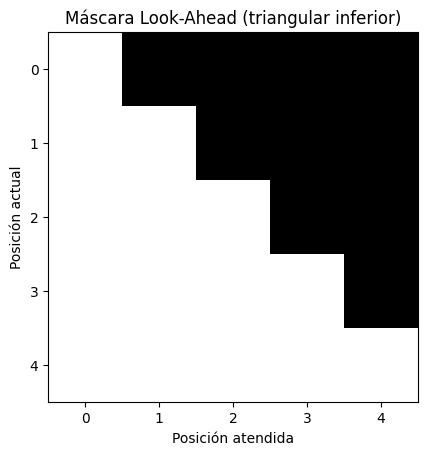

Salida del bloque del decoder:
 [[[ 0.28679209  0.17436264 -1.9423618   0.09916361  0.59907948
   -0.24580714  1.57468108 -0.90713671 -0.99490258 -0.52597409
   -0.03606116 -0.0374539   1.87492826  1.57479213 -0.78031352
   -0.71378839]
  [ 0.29207526  0.16735808 -1.94629645  0.11236685  0.59058851
   -0.24087115  1.58430471 -0.91483629 -0.98833108 -0.52261473
   -0.03695885 -0.03987456  1.86328899  1.57659489 -0.77698497
   -0.71980922]
  [ 0.29318579  0.15594542 -1.95041994  0.10789796  0.58943528
   -0.23755346  1.57815647 -0.92106232 -0.98830226 -0.51815336
   -0.03279125 -0.03778183  1.87085693  1.57490312 -0.76838554
   -0.71593102]
  [ 0.29315648  0.15261816 -1.94984186  0.11397712  0.58975449
   -0.23268727  1.58355046 -0.92520067 -0.98792876 -0.51551548
   -0.03762201 -0.03860961  1.865739    1.5746     -0.76745909
   -0.71853096]
  [ 0.28447612  0.16017535 -1.94377418  0.10398464  0.60015143
   -0.24016018  1.57971543 -0.91577956 -0.99018925 -0.51849757
   -0.03879803 -0.0344

In [23]:
# Prueba 5: Bloque del Decoder + Visualización de máscara

batch_size = 1
seq_len_dec = 5
seq_len_enc = 5
d_model = 16
num_heads = 4
d_ff = 64

decoder_input = np.random.rand(batch_size, seq_len_dec, d_model)
encoder_output = np.random.rand(batch_size, seq_len_enc, d_model)

decoder_input += positional_encoding(seq_len_dec, d_model)

look_ahead_mask = create_look_ahead_mask(seq_len_dec)
look_ahead_mask = look_ahead_mask[np.newaxis, np.newaxis, :, :]  # (1, 1, seq_len, seq_len)

plt.imshow(look_ahead_mask[0, 0], cmap='gray')
plt.title("Máscara Look-Ahead (triangular inferior)")
plt.xlabel("Posición atendida")
plt.ylabel("Posición actual")
plt.show()

decoder = DecoderBlock(d_model, num_heads, d_ff)
out_dec = decoder.forward(decoder_input, encoder_output, look_ahead_mask)

print("Salida del bloque del decoder:\n", out_dec)

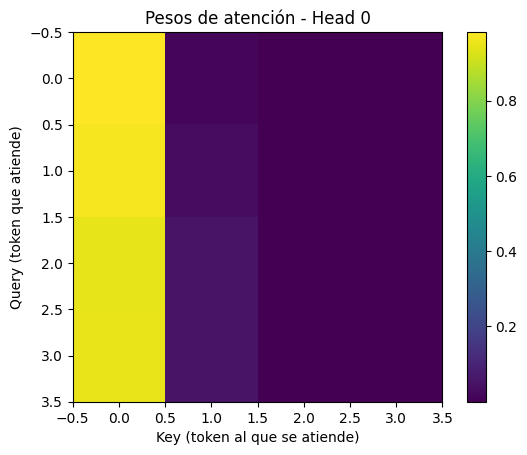

In [25]:
# Visualización de pesos de atención

# Crear datos consistentes con d_model = 16
x = np.random.rand(1, 4, 16)  # (batch, seq_len, d_model)

# Crear Multi-Head Attention con mismo d_model
mha = MultiHeadAttention(d_model=16, num_heads=4)

# Ejecutar y visualizar
_, att_weights = mha.forward(x, x, x)

# Visualizar para la primera cabeza
plt.imshow(att_weights[0, 0], cmap='viridis')  # (seq_len, seq_len)
plt.title("Pesos de atención - Head 0")
plt.xlabel("Key (token al que se atiende)")
plt.ylabel("Query (token que atiende)")
plt.colorbar()
plt.show()